In [35]:
import pandas as pd
data = pd.read_csv("Data_MLB_2025_StatcastPostseason_PitchByPitch_20251102a.csv")

In [36]:
# need features that are available before or during the pitch - or else data leakage
# I also made a heatmap and dropped features that were repetitve w each other (like inning and at_bat_number, 
columns_to_drop = [
    'game_year', 'game_date', 'player_name', 'pitcher', 'batter', 
    'events', 'description', 'des','game_pk', 'release_speed', 'release_pos_y',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated',
    'zone', 'game_type', 'home_team', 'away_team', 'hit_location', 'bb_type', 'delta_home_win_exp', 'delta_run_exp',
    'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'if_fielding_alignment', 'of_fielding_alignment',
    'outs_when_up', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'sz_top', 'sz_bot',
    'fielder_2', 'fielder_2.1', 'fielder_2.2', 'fielder_2.3', 'fielder_3', 'inning', 'inning_topbot',
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'effective_speed',
    'umpire', 'sv_id', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'spin_dir',
    'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'woba_value',
    'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle',  'post_away_score', 'post_home_score',
    'post_bat_score', 'post_fld_score', 'home_score', 'away_score', 'bat_speed', 'swing_length', 'pitch_name'
]

data = data.drop(columns=columns_to_drop)

print(data.columns)
pd.set_option('display.max_columns', None)
print(data.head())



Index(['balls', 'strikes', 'at_bat_number', 'pitch_number', 'pitch_type',
       'release_pos_x', 'release_pos_z', 'stand', 'p_throws', 'type', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'bat_score', 'fld_score', 'spin_axis'],
      dtype='object')
   balls  strikes  at_bat_number  pitch_number pitch_type  release_pos_x  \
0      0        0             73             1         SL          -0.30   
1      1        0             73             2         FC          -0.06   
2      1        1             73             3         SL          -0.18   
3      1        2             73             4         SL          -0.11   
4      1        2             73             5         FC          -0.09   

   release_pos_z stand p_throws type       vx0         vy0       vz0  \
0           6.43     R        R    B  0.109715 -133.806972 -1.288816   
1           6.56     R        R    S -0.626523 -141.845059 -6.110725   
2           6.31     R    

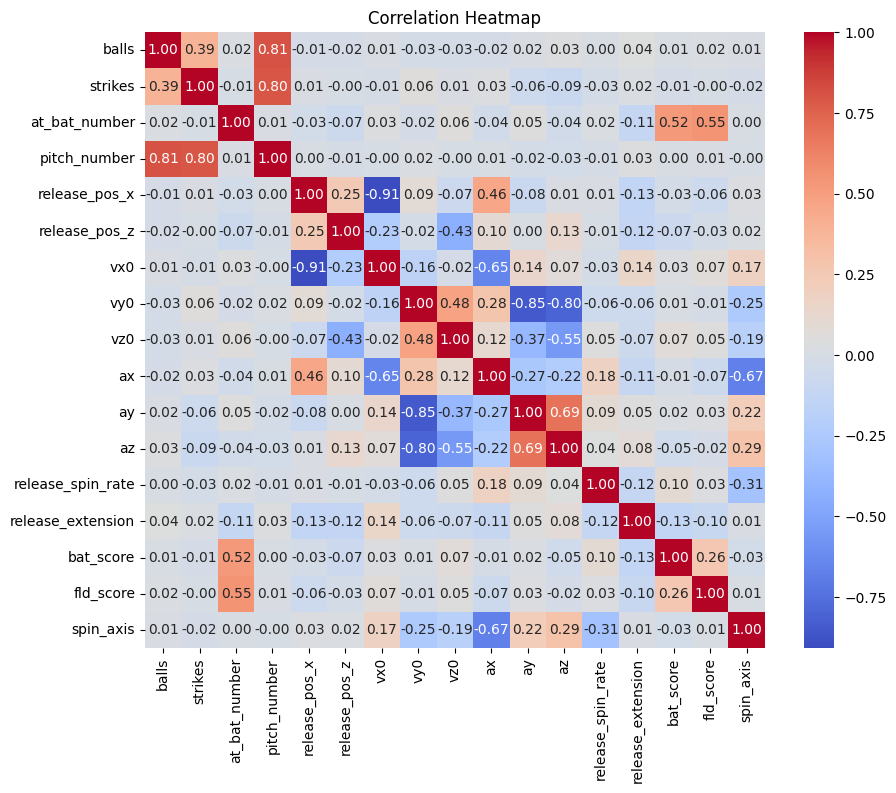

21


In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# compute correlation matrix
corr = data.corr(numeric_only=True)

# plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

print(len(data.columns))

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("feature_visualizations", exist_ok=True)

# Separate numeric and categorical features
numeric_features = [
       'balls', 'strikes', 'at_bat_number', 'pitch_number', 
       'release_pos_x', 'release_pos_z', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'bat_score', 'fld_score', 'spin_axis'
]

categorical_features = ['stand', 'p_throws', 'type', 'pitch_type']  # type is the target

# Numeric Features: Histograms
for col in numeric_features:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], kde=False)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(f"feature_visualizations/{col}_hist.png")
    plt.close()

# Categorical Features: Countplots
for col in categorical_features:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=data)
    plt.title(f'Count of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(f"feature_visualizations/{col}_count.png")
    plt.close()

# Correlation Heatmap for numeric features 
plt.figure(figsize=(12,10))
corr = data[numeric_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.savefig("feature_visualizations/correlation_heatmap.png")
plt.close()


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

y = data['type']
X = data.drop(columns=['type'])

categorical_features = ['stand', 'p_throws', 'pitch_type']
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# ColumnTransformer for encoding
encoder = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Transform the features
X_encoded = encoder.fit_transform(X)

# Split into training and validation (10% for validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_encoded, y, test_size=0.1, random_state=42, stratify=y
)

# Convert NumPy array back to DataFrame
X_train_df = pd.DataFrame(X_train)
X_val_df = pd.DataFrame(X_val)
y_train_df = pd.DataFrame(y_train)
y_val_df = pd.DataFrame(y_val)

# Save to CSV
X_train_df.to_csv('X_train.csv', index=False)
X_val_df.to_csv('X_val.csv', index=False)
y_train_df.to_csv('y_train.csv', index=False)
y_val_df.to_csv('y_val.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

dt_depths = [3, 5, 7, 9, None]
rf_estimators = [50, 100, 200, 300]

# k-fold setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dt_scores = []
for depth in dt_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(dt, X_train, y_train, cv=kf, scoring='accuracy')
    dt_scores.append(np.mean(scores))

plt.figure(figsize=(6,4))
plt.plot([d if d is not None else 10 for d in dt_depths], dt_scores, marker='o')  # None replaced with 10 for plotting
plt.title('Decision Tree: Max Depth vs CV Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Mean CV Accuracy')
plt.tight_layout()
plt.savefig('dt_cv_plot.png')
plt.close()

rf_scores = []
for n in rf_estimators:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    scores = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')
    rf_scores.append(np.mean(scores))

plt.figure(figsize=(6,4))
plt.plot(rf_estimators, rf_scores, marker='o')
plt.title('Random Forest: n_estimators vs CV Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Mean CV Accuracy')
plt.tight_layout()
plt.savefig('rf_cv_plot.png')
plt.close()

In [ ]:
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# WIP

# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=9, random_state=42)

# Measure training time
start_time = time.time()
dt_model.fit(X_train, y_train)
dt_train_time = time.time() - start_time

# Predict on validation set
y_val_pred_dt = dt_model.predict(X_val)

# Evaluate performance
dt_accuracy = accuracy_score(y_val, y_val_pred_dt)
dt_report = classification_report(y_val, y_val_pred_dt)

print(f"Decision Tree Training Time: {dt_train_time:.4f} seconds")
print(f"Decision Tree Validation Accuracy: {dt_accuracy:.4f}")
print("Decision Tree Classification Report:")
print(dt_report)


# Random Forest
start_rf = time.time()

rf_model = RandomForestClassifier(n_estimators=rf_n_estimators, random_state=42)
rf_model.fit(X_train, y_train)

end_rf = time.time()
rf_runtime = end_rf - start_rf

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)

# Accuracy
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
val_acc_rf = accuracy_score(y_val, y_val_pred_rf)

print(f"Random Forest Training Runtime: {rf_runtime:.2f} seconds")
print(f"Random Forest Accuracy - Training: {train_acc_rf:.3f}, Validation: {val_acc_rf:.3f}")


Decision Tree Training Runtime: 0.15 seconds
Decision Tree Accuracy - Training: 0.602, Validation: 0.535
Random Forest Training Runtime: 14.68 seconds
Random Forest Accuracy - Training: 1.000, Validation: 0.612
